In [134]:
!pip install ucimlrepo
!pip install umap-learn
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
%matplotlib inline

In [3]:
#data preprocessing, we have the to remove some columns, and make some changes to the target
data =(pd.read_csv("OnlineNewsPopularity/OnlineNewsPopularity.csv"))
df = data.drop(['url'], axis = 1)
df = df.drop([' timedelta'], axis = 1)
ros = RandomOverSampler(random_state=42)
#timedelta and url are non predictive
X = df.drop([' shares'], axis = 1)
y = df[' shares']
y_bins = np.zeros(len(y))
for i in range(len(y)):
    if (y[i] >= 3000):
        y_bins[i] = 1
X_resampled, y_resampled = ros.fit_resample(X, y_bins)
X, y_bins = X_resampled, y_resampled

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bins, test_size = 0.2, random_state=42)

In [5]:
corr_ = np.zeros(len(X_train.T))
index = np.zeros(len(X_train.T))
for i in range(len(X_train.T)):
    cor = np.corrcoef(y_train, X_train.iloc[:,i])[1,0]
    index[i] = i
    corr_[i] = cor
corr_

array([-0.03191969,  0.01348435,  0.00727533,  0.00713866,  0.00655995,
        0.08657532,  0.01496531,  0.0760625 ,  0.03334877, -0.04305961,
        0.06933189,  0.03044904, -0.0712561 , -0.04141352,  0.07031785,
        0.02780657, -0.14311052,  0.01323941,  0.02753683,  0.03068092,
        0.01046273,  0.00130798,  0.05735642,  0.0976239 ,  0.09800423,
        0.20140467,  0.06492698,  0.06738254,  0.07722438, -0.00869795,
       -0.03038314, -0.02433821, -0.02233613, -0.00270169,  0.05894732,
        0.06913376,  0.09465982,  0.02146635, -0.04026797, -0.15682053,
        0.13043715,  0.01647416,  0.0740543 ,  0.03546264,  0.03850141,
        0.00561601, -0.00090853, -0.0366246 ,  0.03116778, -0.00458239,
        0.02628664, -0.03807505, -0.02345389, -0.01683734,  0.04976189,
        0.04401963,  0.00263798,  0.05460234])

In [6]:
linear_features_X_train = X_train.T[np.absolute(corr_) >= 0.025].T
linear_features_X_test = X_test.T[np.absolute(corr_) >= 0.025].T
nonlinear_features_X_train = X_train.T[np.absolute(corr_) < 0.025].T
nonlinear_features_X_test = X_test.T[np.absolute(corr_) < 0.025].T

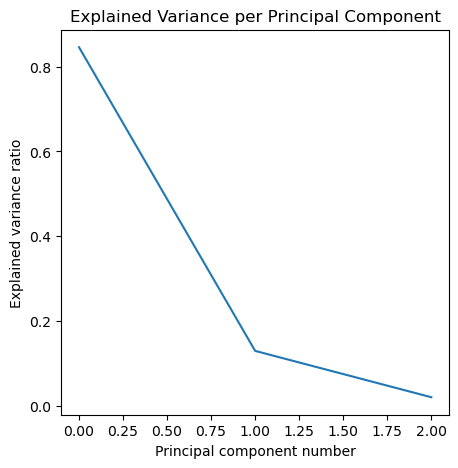

In [7]:
pca_example = PCA(n_components=0.99)
pca_example.fit(linear_features_X_train)
plt.figure(figsize=(5,5))
plt.plot(pca_example.explained_variance_ratio_)
plt.title("Explained Variance per Principal Component")
plt.xlabel("Principal component number")
plt.ylabel("Explained variance ratio")
plt.show()

It is clear that all of the linear features can be reduced to a single linear feature, the first principal component

In [8]:
pca = PCA(n_components=0.99)
linear_features_X_train = pca.fit_transform(linear_features_X_train)
linear_features_X_test = pca.transform(linear_features_X_test)

In [9]:
np.corrcoef(y_train, linear_features_X_train[:,0])[1,0]

0.058666444628156865

In [10]:
X_train = np.hstack((linear_features_X_train, nonlinear_features_X_train))
X_test = np.hstack((linear_features_X_test, nonlinear_features_X_test))

In [11]:
param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'estimator': [DecisionTreeClassifier(max_depth=depth) for depth in [1, 2, 3]]
    }

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'estimator': [DecisionTreeClassifier(max_depth=1),
                                       DecisionTreeClassifier(max_depth=2),
                                       DecisionTreeClassifier(max_depth=3)],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [12]:
y_preds = grid_search.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68      6074
         1.0       0.68      0.69      0.69      6074

    accuracy                           0.69     12148
   macro avg       0.69      0.69      0.69     12148
weighted avg       0.69      0.69      0.69     12148



In [13]:
help(KNeighborsClassifier)

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighb

In [14]:
param_grid = {
    'n_neighbors': [10, 15, 20],
    'algorithm': ['ball_tree','kd_tree'],
    'leaf_size': [15, 20, 25, 30]
}
grid_search = GridSearchCV(KNeighborsClassifier(n_jobs=-1), param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=15, n_jobs=-1,
                     n_neighbors=10)

In [15]:
y_preds = grid_search.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.64      0.66      0.65      6074
         1.0       0.65      0.62      0.63      6074

    accuracy                           0.64     12148
   macro avg       0.64      0.64      0.64     12148
weighted avg       0.64      0.64      0.64     12148



# 1. Problem statement

    1)Choice of an interesting, modern, useful application. Preferably not a first-world problem.

    2)Clear, concise description of the problem statement, its importance, and difficulties associated with it.

    3)Clear objectives: state whether the focus is prediction accuracy and/or interpretation, regression or classification? Try to limit the scope.

    4)Remember to provide references of work in the literature related to the problem of interest. You
    have to research what has already been done in the field.
    
    5)End with all references for the current approach.

We have chosen to focus our research and statistical learning application in the domain of social networks. Specifically with regards to predicting online social behavoir, in the form of identifying which pieces of media are likely to gain popularity. 

Popularity prediction, or virality prediction, is the practice of using some predictive / regession model trained to predict wether a new piece of online media will go viral, which is to say that it will be viewed by a large amount of people. The most common / recognised mechanism for internet content to attain virality is though shares. When users send the article, video, tweet to other users, who might in turn do the same. 

importance:
-Enhancing News Relevance
-Audience Engagement
-Rising Importance of Digital Media Literacy
-Erosion of Trust in Media
-Political Polarization and Disinformation Campaigns
-Resilience Against Information Warfare

difficulties:
-interpretation 
-constant changes in public appeal and opinions 
-data collection <- tracking if media is shared (mostly off socail media platforms)


Therefore the goal is it create a model that is capable of predicting what content will recive the most shares. 


With the goal in hand, we searched and found a data set that summarized features of thousands of aritcles published by the news / media platform mashable. Then we will be attempting to improve upon the methods of ernandes, Kelwin, Pedro Vinagre, and Paulo Cortez. "A proactive intelligent decision support system for predicting the popularity of online news." In Portuguese Conference on Artificial Intelligence, pp. 535-546. Springer, Cham, 2015.
### TODO add refs to other literature in this field

# 2. Data description

### Conciseness and clarity of the data description, including:

    (1)The data source (include references)
    
    (2)The size of n and p, the response, and a concise summary of the types of predictors (an idea of what kinds of measurements were taken, how many numeric, and how many categorical). Partitioning of the data into   training-and test sets. In classification: are there class imbalances?

    (3)Remarks regarding potential data problems (outliers, missing values, omitted variables, etc.)

The data contains 39644 observations, and 61 features. Some of the predictors are non-informative, and will be removed, this includes the url feature, that just contains the link to the article. All of the predictors are numerical, which some being continuous, some strictly integer, and some categorical. 

The features are summarises of the various aspects of a new / media article, this includes, but not limited to, date of publication, number of words in the title or in the body, keywords used, seniment of the words used, subjectivity rating, political polarity rating, number of images and videos. These are a few example, to demonstrate the feature / predictor space. 

we will be following a similary methodology to the current model, in which the target variable is to be paritioned into varying degress of popularity based on the integer value of the target, shares, variable. This way we can apply classification models to the data. 

There are no missing values, however in the partitioning step, which we will expand upon later, we do have an imbalance in the number of observations per class. There are some potencial outliers, instances where the number of shares is far far greater than many standard deviations from the mean. 

## 3. The current approach

    (1) Section 3 should be easy to follow and make sense to someone new to the problem.
    
    (2)Focus only on the key steps and hide unnecessary detail.
    
    (3)Include flow diagrams/graphs/tables that clarify the process. Clearly indicate whether the training- or test data was used in each step.

    (4)Include the types of models considered, whether variable selection/dimension reduction were considered, and parameter values considered when tuning models

    (5)Include motivations/your critique with respect to each modelling aspect.

The current approach
    - classification to predict the popularity of the online news.
    - Random Forest, Bayes Net, Logistic Function, C4.5 and Simple Cart.
    - The performance of the five models is evaluated by some of the most popular metrics such as Accuracy, Root Mean Square Error (RMSE), Kappa Statistic, TP-Rate, FP-Rate, Precision, F-Measure and ROC Area values.
    - feature filtering techniques are applied in the study to improve the model's performance
    -  Moreover, for dividing the dataset into a training and testing set, 10-fold cross- validation was used.
    

The methodology for the current model is as follows:

preprocessing:

The author starts by transforming the numerical target variable, sales, into a binary categorical variable. The two classes are "Yes" indicating a high number of shares and "No" indicating a low number of shares. A high number of shares is defined as being greater than of equal to 1400, it is unclear how the author came to chose this as the class separation value, and further investigation into differnt boundry values will be discussed later in our approach. 

This categorization of the data leads to very similar sizes in observations of "Yes" and "No", but the difference is resolved by taking a balanced subset of the original data. 

there are no missing values or uneven columns in the data, therefore this completed the preprocessing stage. 

Constructing the classification models:

The paper contains five classification models, and 



# 4. Potential problems with the current approach

    (1)Provide a summary of each step in the current approach.

    (2)Summarise potential problems or shortcomings with the current approach (or motivate why there aren’t any).

    (3)Identify options for extending the current approach or outcomes, and their potential benefits. All considered options should be sensible and well motivated.

    (4) Show creative/innovative/critical thinking: what steps could have been omitted, what steps could have been added, what other aspects could have been addressed? Select the options in (2)-(4) to be furtherinvestigated, and motivate your choices.

# 5. The new approach

    (1)Start with a summary of the new approach.

    (2)Cover all important modelling aspects. Mention all options that were investigated. Hide unnecessary detail. Do not elaborate on options that were investigated, but that did not lead to improvements.

    (3)Use tables/figures/graphs to highlight the effects of changes to the current approach.

# 6. A comparison of model results

    (1) If appropriate, a comparison of results in terms of both prediction accuracy and interpretation. Appropriate performance measures.
   
    (2) In summary format (results of both approaches in table format). Include figures.

    (3) Highlight improvements in your discussion (lead the reader through the results and to a conclusion).

# 7. Actionable insights

Answer the “so what?” question. How can the new
approach be used to make a difference?

# 8. Reflection

Briefly indicate what you have learnt. What worked
well, or what would you like to change ‘next time’? If
you had more time, what would you further consider
or might a team member want to improve upon when
considering the project?